# Entrance Challenge: When Will the Sakura Bloom?

***

**Name： AI 14** 

**Submission Date：1/12/2017 **

***

# Preprocessing of the feature set provided

1.Importing the required libraries:

In [66]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import statistics as sts
from sklearn import metrics
import re
import math
from sklearn import neural_network 
import numpy as np
from sklearn import preprocessing 
import calendar
import numpy as np
import random 
from sklearn.model_selection import train_test_split

2.Importing the features provided to a dataframe:

In [67]:
sakuraFeatures=pd.read_csv("data.csv",index_col=['serial'])

3.Combining the day, month and year to create the date column:

In [68]:
#### ADDING DATE COLUMN TO THE sakuraFeatures DATAFRAME ####
date=pd.DataFrame({})
date=pd.concat([date,sakuraFeatures["year"],sakuraFeatures["month"],sakuraFeatures["day"]],axis=1)
date=(pd.to_datetime(date)).dt.date
sakuraFeatures["date"]=date

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2017 using the Japanese Meteorological Agency website (気象庁).

# Bloom Date Extraction from the Japan Meterological agency website

THE ROW OF BLOOM DATES WERE COPIED FROM THE WEBSITE TO A TEXT FILE (.txt) WHICH IS PROCESSED FOR FURTHUR USE. THE STEPS ARE SHOWN BELOW CHRONOLOGICALLY.

1.Reading the text file:

In [69]:
fileBloomDate=open("bloom_date.txt","r+")
raw='start'
data,proData=[],[]
i=0
while raw!='':
    raw=fileBloomDate.readline()
    if raw=='':
        break

    data=data+[raw.strip().split(',')]
    proData=proData+[data[i][0].split()]
    i=i+1
fileBloomDate.close()

2.Converting the string data to integer data:

In [70]:
for i in range(len(proData)):
    for j in range(len(proData[i])):
        proData[i][j]=int(proData[i][j])

3.Processing the data to create the BLOOM DATE dataframe:

In [71]:
year=1961
i=0
month,day,years=[],[],[]
while year<2017:
    if proData[i][0] == year:
        month = month + [proData[i+1][(2 * j)] for j in range(len(proData[i]))]
        day = day + [proData[i+1][(2 * j) + 1] for j in range(len(proData[i]))]
        years=years+[year+i for i in range(len(proData[i]))]
        year += 10
    if i<11:
        i+=1

4.Creating the BLOOM DATE dataframe in datetime format:

In [72]:
bd={"year":years,"month":month,"day":day}
bloomDate=pd.DataFrame(bd,index=None,columns=['year','month','day']) 
#### CONVERTING THE BLOOM DATE TO DATETIME ####
bloomModifiedDate=pd.DataFrame({})
bloomModifiedDate=pd.concat([bloomModifiedDate,bloomDate["year"],bloomDate["month"],bloomDate["day"]],axis=1)
bloomModifiedDate=(pd.to_datetime(bloomModifiedDate)).dt.date
bloomModifiedDate

0     1961-04-01
1     1962-04-01
2     1963-04-01
3     1964-04-02
4     1965-04-02
5     1966-03-20
6     1967-03-30
7     1968-03-29
8     1969-04-06
9     1970-04-07
10    1971-03-30
11    1972-03-28
12    1973-03-31
13    1974-04-02
14    1975-03-29
15    1976-03-22
16    1977-03-22
17    1978-03-31
18    1979-03-23
19    1980-03-31
20    1981-03-26
21    1982-03-23
22    1983-03-31
23    1984-04-11
24    1985-04-03
25    1986-04-03
26    1987-03-23
27    1988-04-02
28    1989-03-20
29    1990-03-20
30    1991-03-30
31    1992-03-24
32    1993-03-24
33    1994-03-31
34    1995-03-31
35    1996-03-31
36    1997-03-21
37    1998-03-27
38    1999-03-24
39    2000-03-30
40    2001-03-23
41    2002-03-16
42    2003-03-27
43    2004-03-18
44    2005-03-31
45    2006-03-21
46    2007-03-20
47    2008-03-22
48    2009-03-21
49    2010-03-22
50    2011-03-28
51    2012-03-31
52    2013-03-16
53    2014-03-25
54    2015-03-23
55    2016-03-21
56    2017-03-21
dtype: object

***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

IN THIS PART OF THE PROBLEM, THE TEST AND THE TRAIN SETS ARE SEPARATED.AFTER THIS, AS ASKED IN THE PROBLEM, THE ACCUMULATED DAILY MAXIMUM TEMPERATUR FOR EACH YEAR FROM FEBRUARY 1ST TO BLOOM DATE ARE CALCULATED. THIS IS THEN USED TO CALCULATE Tmean. IN THE CALCULATION BELOW, IT WAS OBSERVED THAT Tmean WAS VERY CLOSE TO 600 DEGREE CELCIUS AND HENCE THIS RULE CAN BE USED FOR BLOOM DATE PREDICTION. STEP WISE PROCEDURE IS SHOWN BELOW.

1.Creating test and train datasets:

testYears: contains the test years,
trainyears: contains the train years,
TrainSet: contains the corresponding features of the train years,
TestSet: contains the corresponding features of the test years,
trainBloomDateM: contains the bloom dates of the train years,
testBloomDateM: contains the bloom dates of the test years

In [73]:
#### INITIALIZING REQUIRED VARIABLES ####
TrainSet=sakuraFeatures
trainBloomDate=bloomDate
TestSet,testBloomDate,TestBloomDate=pd.DataFrame({}),pd.DataFrame({}),pd.DataFrame({})

#### SEPARATING TEST AND TRAIN YEARS ####
testYears=[1966,1971,1985,1994,2008]
trainYears=[i for i in range(1961,2018)]
trainYears=[x for x in trainYears if x not in testYears]

#### SEPARATING TEST AND TRAIN FEATURE SETS ####
for j in range(len(testYears)):
    for i in range(len(TrainSet.loc[TrainSet["year"] == testYears[j]])):
            testSet=TrainSet.loc [TrainSet["year"] == testYears[j]]
            TestSet=pd.concat([TestSet,testSet])
            testBloomDate=trainBloomDate.loc [trainBloomDate["year"] == testYears[j]]
            TestBloomDate=pd.concat([TestBloomDate,testBloomDate])
            TrainSet = TrainSet[TrainSet.year != testYears[j]]
            trainBloomDate=trainBloomDate[trainBloomDate.year !=testYears[j]]
        
#### CONVERTING BLOOM DATES TO DATETIME ####
trainBloomDateM=pd.to_datetime(trainBloomDate).dt.date
testBloomDateM=pd.to_datetime(TestBloomDate).dt.date


2.Resetting the index of the train and test DataFrames:

In [74]:
TrainSet=TrainSet.reset_index(drop=True)
TestSet=TestSet.reset_index(drop=True)
trainBloomDateM=trainBloomDateM.reset_index(drop=True)
testBloomDateM=testBloomDateM.reset_index(drop=True)

In [75]:
print("Train Bloomdates\n",trainBloomDateM)
print("Test Bloomdates\n",testBloomDateM)

Train Bloomdates
 0     1961-04-01
1     1962-04-01
2     1963-04-01
3     1964-04-02
4     1965-04-02
5     1967-03-30
6     1968-03-29
7     1969-04-06
8     1970-04-07
9     1972-03-28
10    1973-03-31
11    1974-04-02
12    1975-03-29
13    1976-03-22
14    1977-03-22
15    1978-03-31
16    1979-03-23
17    1980-03-31
18    1981-03-26
19    1982-03-23
20    1983-03-31
21    1984-04-11
22    1986-04-03
23    1987-03-23
24    1988-04-02
25    1989-03-20
26    1990-03-20
27    1991-03-30
28    1992-03-24
29    1993-03-24
30    1995-03-31
31    1996-03-31
32    1997-03-21
33    1998-03-27
34    1999-03-24
35    2000-03-30
36    2001-03-23
37    2002-03-16
38    2003-03-27
39    2004-03-18
40    2005-03-31
41    2006-03-21
42    2007-03-20
43    2009-03-21
44    2010-03-22
45    2011-03-28
46    2012-03-31
47    2013-03-16
48    2014-03-25
49    2015-03-23
50    2016-03-21
51    2017-03-21
dtype: object
Test Bloomdates
 0    1966-03-20
1    1971-03-30
2    1985-04-03
3    1994-03-31
4  

3.Calculating the accumulated daily Maximum temperature:

In [76]:
totalMaxTemp=[]
initialDate=[dt.date(trainYears[i],2,1) for i in range(len(trainYears))]
for i in range(len(initialDate)):
    maxTemp=0
    for j in range(len(TrainSet)):
        if TrainSet["date"][j]>=initialDate[i] and TrainSet["date"][j]<=trainBloomDateM[i]:
            maxTemp=maxTemp+TrainSet["max temp"][j]
    totalMaxTemp.append([initialDate[i].year,maxTemp])
totalMaxTemp_df=pd.DataFrame( totalMaxTemp,columns=["year","Total Max temp"])

4.Calculating Tmean (Mean accumulated Daily max temp):

In [77]:
Tmean= sts.mean(totalMaxTemp_df["Total Max temp"])
print("Tmean = ", Tmean)

Tmean =  638.355769231


5.Plotting the accumulated daily Maximum temperature of each year:

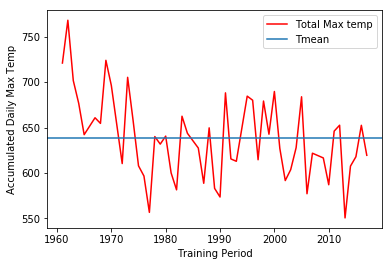

In [78]:
plt.plot(totalMaxTemp_df["year"],totalMaxTemp_df["Total Max temp"],'r')
plt.axhline(y=Tmean,label="Tmean")
plt.xlabel("Training Period")
plt.ylabel("Accumulated Daily Max Temp")
plt.legend()
plt.show()

SINCE THE AVERAGE VALUE IS GREATER THAN 600 DEGREES AND CLOSE TO 600, IT CAN BE USED AS AN INDICATOR FOR CHERRY BLOSSOM BLOOM DATE. BUT IT CAN BE USED ONLY FOR A VAGUE IDEA OF THE BLOOM DATE BUT NOT FOR AN ACCURATE ONE.

### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

IN THIS PART, 600 DEGREE CELCIUS AND Tmean ARE USED AS THE THRESHOLD TO PREDICT THE BLOOM DATES FOR THE TEST YEARS. AFTER PREDICTING, THE ERROR AND R2 SCORE VALUES ARE SHOWN. STEPWISE PROCEDURE ARE SHOWN BELOW.

1.Defining function for prediction with desired threshold total temp:

In [79]:
initialDateTest=[dt.date(testYears[i],2,1) for i in range(len(testYears))]
#### FUNCTION FOR PREDICTING ####
def BD_predict(threshold,initial=initialDateTest):
    totalMaxTempTest,predictedBloomDate=[],[]
    predictedDate=0
    for i in range(len(initial)):
        maxTemp=0
        for j in range(len(TestSet)):
            if TestSet["date"][j]>=initial[i] and maxTemp<=threshold:
                maxTemp=maxTemp+TestSet["max temp"][j]
                predictedDate=TestSet["date"][j]
        predictedBloomDate.append(predictedDate)
    return predictedBloomDate

2.Calculating the r2score for both Tmean and 600 as thresholds:

In [80]:
#### PREDICTING BLOOM DATE FOR Tmean AND 600 DEGREE CELCIUS ####
predictedBloomDateTmean=BD_predict(Tmean)
predictedBloomDate600=BD_predict(600)

#### CONVERTING DATES TO DAYS FROM FEBRUARY 1ST OF EACH YEAR FOR ACTUAL AND PREDICTED BLOOM DATES ####
actualDays=[(testBloomDateM[k]-initialDateTest[k]).days for k in range(len(testYears))]
predictedDaysTmean=[(predictedBloomDateTmean[i]-initialDateTest[i]).days for i in range(len(testYears))]
predictedDays600=[(predictedBloomDate600[k]-initialDateTest[k]).days for k in range(len(testYears))]

#### ERROR FROM THE ACTUAL BLOOM DATES ####
errorTmean=[(actualDays[i]-predictedDaysTmean[i]) for i in range(len(predictedDaysTmean))]
error600=[(actualDays[i]-predictedDays600[i]) for i in range(len(predictedDays600))]

#### CALCULATING THE R2 SCORES FOR EACH PREDICTED RESULTS ####
r2scoreTmean=metrics.r2_score(actualDays,predictedDaysTmean)
r2score600=metrics.r2_score(actualDays,predictedDays600)

#### PRINTING THE RESULTS ####
print("R2 score and error for Tmean respectively:")
print(r2scoreTmean*100, errorTmean)
print("R2 score and error for 600 respectively:")
print(r2score600*100, error600)

R2 score and error for Tmean respectively:
83.2361516035 [-3, 1, 2, 0, -3]
R2 score and error for 600 respectively:
67.9300291545 [0, 3, 5, 3, -1]


***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

IN THIS PORTION OF THE QUESTION, THE LINEAR REGRESSION MODEL IS VERIFIED

1.Calculating initial and end dates of the 3 months for required avg. temp:

intialDateAvgTrain: 1st january of each train years, intialDateAvgTest:1st january of each test years, endDateAvgTrain: 31st march of each train years, endDateAvgTest: 31st march of each test years

In [81]:
initialDateAvgTrain=[dt.date(trainYears[i],1,1) for i in range(len(trainYears))]
endDateAvgTrain=[dt.date(trainYears[i],3,31) for i in range(len(trainYears))]
initialDateAvgTest=[dt.date(testYears[i],1,1) for i in range(len(testYears))]
endDateAvgTest=[dt.date(testYears[i],3,31) for i in range(len(testYears))]

2.Calculating the avg temp over the first 3 months of each train and test years:

In [82]:
#### FUNCTION FOR CALCULATING THE TOTAL AVERAGE TEMPERATURE FOR ANY TIME PERIOD ####
def avg_temp(initial,end,years,SET):
    totalAvg=[]
    for i in range(len(years)):
        mask=(SET["date"]>=initial[i]) & (SET["date"]<=end[i])
        totalAvg.append([years[i],SET.loc[mask]["avg temp"].mean()])
    return totalAvg
trainTotalAvg_df=pd.DataFrame(avg_temp(initialDateAvgTrain,endDateAvgTrain,trainYears,TrainSet),columns=["year","avg temp"])
testTotalAvg_df=pd.DataFrame(avg_temp(initialDateAvgTest,endDateAvgTest,testYears,TestSet),columns=["year","avg temp"])

3.Converting latitude to decimal degrees:

In [83]:
def dms2dd(degrees,minutes,seconds,direction):
    dd=int(degrees)+int(minutes)/60+int(seconds)/3600
    if direction=='N':
        dd*=+1
    else:
        dd*=-1
    return dd
    
lat="35°40'00'N"
parts=re.split('[^\d\w]+',lat)
latDegrees=dms2dd(parts[0],parts[1],parts[2],parts[3])

4.Defining function for Dj:

In [84]:
def dj(Tf,lat=latDegrees,L=4):
    Dj=136.75-(7.689*lat)+(0.133*lat**2)-(1.307*math.log(L))+0.144*Tf+0.285*Tf**2
    return math.floor(Dj)


4.Calculating and plotting Dj:

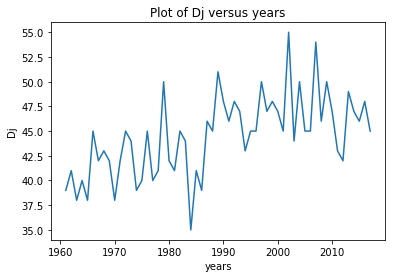

In [85]:
#### CALCULATING Dj FOR THE ENTIRETIME PERIOD UNDER OBSERVATION ####
years=range(1961,2018)
initialDateAvg=[dt.date(years[i],1,1) for i in range(len(years))]
endDateAvg=[dt.date(years[i],3,31) for i in range(len(years))]
totalAvgTemp=avg_temp(initialDateAvg,endDateAvg,years,sakuraFeatures)
DJ=[dj(totalAvgTemp[i][1]) for i in range(len(years))]
plt.plot(years,DJ)
plt.title("Plot of Dj versus years")
plt.xlabel("years")
plt.ylabel("Dj")
plt.show()
#### CALCULATING Dj FOR TRAIN AND TEST YEARS ####
DjTrain=[dj(trainTotalAvg_df["avg temp"][i]) for i in range(len(trainYears))]
DjTest=[dj(testTotalAvg_df["avg temp"][i]) for i in range(len(testYears))]

6.Determining the hibernation end dates for train and test data:

In [86]:
initialHiberTrain=[dt.date(i,1,1) for i in trainYears]
endHiberTrain=[(initialHiberTrain[i]+dt.timedelta(days=DjTrain[i]-1)) for i in range(len(trainYears))]
initialHiberTest=[dt.date(i,1,1) for i in testYears]
endHiberTest=[(initialHiberTest[i]+dt.timedelta(days=DjTest[i]-1)) for i in range(len(testYears))]

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


1.Separating the avg temp of the required train and test years:

In [87]:
def yearly_avg_temp(SET,years,hiber,bloom):
    yearlyAvgTemp=[]
    for i in range(len(years)):
        for j in range(len(SET)):
            if SET["date"][j]>=hiber[i] and SET["date"][j]<=bloom[i]:
                yearlyAvgTemp.append([years[i],SET["avg temp"][j]])
    return  yearlyAvgTemp

yearlyAvgTempTrainDF=pd.DataFrame(yearly_avg_temp(TrainSet,trainYears,endHiberTrain,trainBloomDateM),columns=["year","avg temp"])
yearlyAvgTempTestDF=pd.DataFrame(yearly_avg_temp(TestSet,testYears,endHiberTest,testBloomDateM),columns=["year","avg temp"])


2.Initializing required functions for unit conversion and calculation:

In [88]:
R=8.314
Ea=[i for i in range(5,41)]

def Ts(E,T,Ts=290):
    E1=E*4184
    T1=T+273
    return math.exp((E1*(T1-Ts))/(R*T1*Ts))

3.Calculating DTS for train years

In [89]:
def DTS(years,yearlyAvgTemp):
    DTS_list=[]
    for i in range(len(years)):
        for e in Ea:
            DTS=0
            for j in range(len(yearlyAvgTemp)):
                if yearlyAvgTemp["year"][j]==years[i]:
                    DTS=DTS+Ts(e,yearlyAvgTemp["avg temp"][j])
            DTS_list.append([years[i],e,DTS])
    return DTS_list
    
DTS_df=pd.DataFrame(DTS(trainYears,yearlyAvgTempTrainDF),columns=["train year","Ea","DTS"])    


4.Calculating the DTS mean over the training period as a function of Ea:

In [90]:
DTSmeanTrain=[sts.mean(DTS_df["DTS"][DTS_df["Ea"]==e]) for e in Ea]

5.Plotting the DTS against Ea:

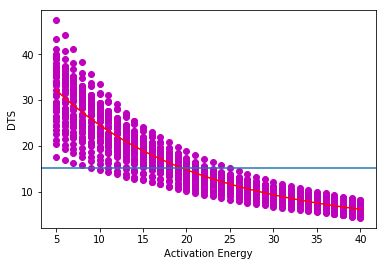

In [91]:
for i in range(len(trainYears)-1):
    plt.plot(DTS_df["Ea"][DTS_df["train year"]==trainYears[i]],DTS_df["DTS"][DTS_df["train year"]==trainYears[i]],'mo')
    plt.xlabel("Activation Energy")
    plt.ylabel("DTS")

plt.plot(Ea,DTSmeanTrain,'r',label='Dmean')
plt.axhline(y=sts.mean(DTS_df["DTS"]),label="global mean")
plt.show()            

### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

1.Determining the bloom date for training data:

In [92]:
bloomdatePredictedTrain=[]
month=[1,5,6,7,8,9,10,11,12]
train=TrainSet
test=TestSet
for i in range(len(month)):
    train=train[train["month"]!=month[i]]
    test=test[test["month"]!=month[i]]

train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

for i in range(len(trainYears)):
     for e in range(len(Ea)):
        DTS=0
        for j in range(len(train)):
            if train["date"][j]>=endHiberTrain[i]:
                if DTS<=DTSmeanTrain[e]:
                    DTS=DTS+Ts(Ea[e],train["avg temp"][j])
                    bloomdatePredict=train["date"][j]
                else:
                    j=len(train)
                
        bloomdatePredictedTrain.append([Ea[e],bloomdatePredict])
        
bloomdatePredictedTrain_df=pd.DataFrame(bloomdatePredictedTrain,columns=["Ea","bloom date"])    
print ("done")

done


2.Calculating the error between the two bloom dates (predicted and actual) 

In [93]:
error_list=[]

for j in range(len(trainBloomDateM)):
    error=[]
    for i in range(len(bloomdatePredictedTrain_df)):
        if bloomdatePredictedTrain_df["bloom date"][i].year==trainBloomDateM[j].year:
            error=((bloomdatePredictedTrain_df["bloom date"][i]-trainBloomDateM[j]).days)**2
            error_list.append([bloomdatePredictedTrain_df["Ea"][i],error])
error_df=pd.DataFrame(error_list,columns=["Ea","ErrorSquared"])   

3.Calculating the mean of the squared error:

In [94]:
MSE_list=[]
for e in range(len(Ea)):
    for i in range(len(error_df)):
        if error_df["Ea"][i]==Ea[e]:
            MSE=error_df.loc[error_df["Ea"]==Ea[e]]["ErrorSquared"].mean()
    MSE_list.append([Ea[e],MSE])
MSE_df=pd.DataFrame(MSE_list,columns=["Ea","MSE"])

4.Plotting the mean square error:

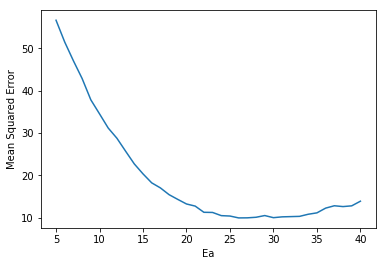

In [95]:
plt.plot(Ea,MSE_df["MSE"])
plt.xlabel("Ea")
plt.ylabel("Mean Squared Error")
plt.show()

5.Determining the optimal Ea:

In [96]:
optimal_Ea=MSE_df.loc[MSE_df["MSE"]==min(MSE_df["MSE"])]["Ea"]

print("Optimal Ea \n",optimal_Ea)

Optimal Ea 
 21    26
Name: Ea, dtype: int64


### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

1.Calculating the predicted Bloom dates of the test years:

In [97]:
bloomdatePredictedTest=[]
DTSmeanTest=DTSmeanTrain[optimal_Ea.index[0]]
for i in range(len(testYears)):

    DTS=0
    for j in range(len(TestSet)):
        if TestSet["date"][j]>=endHiberTest[i]:
            if DTS<=DTSmeanTest:
                DTS=DTS+Ts(optimal_Ea.values[0],TestSet["avg temp"][j])
                bloomdatePredict=TestSet["date"][j]
    bloomdatePredictedTest.append(bloomdatePredict)

2.Calculating the days between actual date and hiberEndTest:

In [98]:
actualDays=[(testBloomDateM[i]-endHiberTest[i]).days for i in range(len(testYears))]
predictedDays=[(bloomdatePredictedTest[i]-endHiberTest[i]).days for i in range(len(testYears))]
r2score=metrics.r2_score(actualDays,predictedDays)
print("r2_DTS:")
print(r2score*100)

r2_DTS:
96.705107084


### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

WHILE WORKING WITH THE PREVIOUS MODEL, WE CONSIDERED MEAN SQUARED ERROR FOR THE DETERMINATION OF OPTIMAL Ea FOR THE PREDICTION OF THE TEST YEAR BLOOM DATES INSTEAD OF USING THE r2 SCORE. IN THIS SECTION, THE RESULT WAS COMPARED WHEN THE r2 SCORE WAS USED FOR THE DETERMINATION OF OPTIMAL Ea FROM THE TRAINING DATA.

1.Calculating the number of days of the predicted bloom date and the actual bloom date from the end date of hibernation phase:

In [99]:
days_predict=[]
for j in range(len(endHiberTrain)):
    days=[]
    for i in range(len(bloomdatePredictedTrain_df)):
        if bloomdatePredictedTrain_df["bloom date"][i].year==endHiberTrain[j].year:
            days=((bloomdatePredictedTrain_df["bloom date"][i]-endHiberTrain[j]).days)
            days_predict.append([bloomdatePredictedTrain_df["bloom date"][i].year,bloomdatePredictedTrain_df["Ea"][i],days])
days_predict_df=pd.DataFrame(days_predict,columns=["years","Ea","days"])   
days_actual=[(trainBloomDateM[i]-endHiberTrain[i]).days for i in range(len(trainYears))]


2.Calculating the r2 score for each of Ea value over the training years:

In [100]:
r2=[]
for e in range(len(Ea)):
    l=days_predict_df["days"][days_predict_df["Ea"]==Ea[e]]
    r2.append([Ea[e],metrics.r2_score(days_actual,l)])
r2_df=pd.DataFrame(r2,columns=["Ea","r2"])

3.Plotting the r2 score versus Ea:

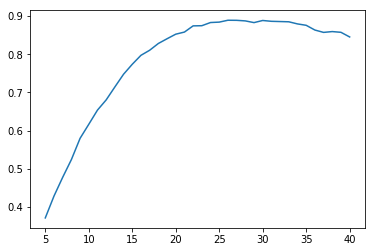

In [101]:
plt.plot(r2_df["Ea"],r2_df["r2"])
plt.show()

4.Determing the optimal Ea:

In [102]:
optimal_Ea_r2=r2_df.loc[r2_df["r2"]==max(r2_df["r2"])]["Ea"]

print("Optimal Ea \n",optimal_Ea_r2)

Optimal Ea 
 21    26
Name: Ea, dtype: int64


5.Predicting the bloom dates for the test years:

In [103]:
bloomdatePredictedTest_r2=[]
DTSmeanTest=DTSmeanTrain[optimal_Ea_r2.index[0]]
for i in range(len(testYears)):

    DTS=0
    for j in range(len(TestSet)):
        if TestSet["date"][j]>=endHiberTest[i]:
            if DTS<=DTSmeanTest:
                DTS=DTS+Ts(optimal_Ea_r2.values[0],TestSet["avg temp"][j])
                bloomdatePredict_r2=TestSet["date"][j]
    bloomdatePredictedTest_r2.append(bloomdatePredict_r2)

6.Calculating the r2 score:

In [104]:
predictedDays_r2=[(bloomdatePredictedTest_r2[i]-endHiberTest[i]).days for i in range(len(testYears))]
r2score_2=metrics.r2_score(actualDays,predictedDays_r2)
print("r2 using r2 score and MSE respectively:")
print(r2score_2*100,r2score*100)

r2 using r2 score and MSE respectively:
96.705107084 96.705107084


NO SIGNIFICANT DIFFERENCE WAS FOUND IN THE ACCURACY. PREFERABLY r2 SCORE IS A BETTER OPTION SINCE IT TAKES THE DEVIATION FROM THE MEAN INTO COSIDERATION.

***
## 3. Predicting Bloom-date via Neural Network (30pts total)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

THE DATA PROVIDED IS PROCESSED IN A MANNER SO THAT ALL IMPORTANT INFORMATION ARE INCLUDED. THE DATA FOR EACH YEAR ARE FLATTENED AND PUT IN ONE ROW. FOR EASIER COMPUTATION, THE 29TH DAY OF FEBRUARY WERE EXCLUDED. ALSO, SINCE THE ENTIRE DATA SET OF 2017 WASN'T PRESENT, IT WAS REMOVED FROM THE TRAIN DATA. SOME FEATURES WERE DROPPED AS WELL (explained in problem 4).

1.Removing the 29th day of February in leap year:

In [105]:
def remove_29thFeb(years,SET):
    leap=[]
    for i in range(len(years)):
        if calendar.isleap(years[i])==True:
            leap.append(dt.date(years[i],2,29))
    for i in range(len(leap)): 
        SET=SET[SET["date"]!=leap[i]]
    return SET
TrainSet=remove_29thFeb(trainYears,TrainSet)
TestSet=remove_29thFeb(testYears,TestSet)

2.Keeping only the first 3 months of data:

In [106]:
month=[4,5,6,7,8,9,10,11,12]
for i in range(len(month)):
    TrainSet=TrainSet[TrainSet["month"]!=month[i]]
    TestSet=TestSet[TestSet["month"]!=month[i]]

3.Removing features that shows least effect on the bloom date:

In [107]:
trainTarget=[(trainBloomDateM[i]-dt.date(trainYears[i],1,1)).days for i in range(len(trainYears)-1)]
trainFeature=TrainSet.drop(["day","month","date","total preci","hr1 preci","min10 preci","local pressure","sea pressure"],axis=1)
testTarget=[(testBloomDateM[i]-dt.date(testYears[i],1,1)).days for i in range(len(testYears))]
testFeature=TestSet.drop(["day","month","date","total preci","hr1 preci","min10 preci","local pressure","sea pressure"],axis=1)

4.Creating xtrain,ytrain,xtest,ytest:

In [108]:
xtrain,xtest=[],[]
for i in range(len(trainYears)-1):
    xtrain.append(trainFeature.loc[trainFeature["year"]==trainYears[i]].values.flatten().tolist())
ytrain=trainTarget[0:(len(trainTarget))]
for i in range(len(testYears)):
    xtest.append(testFeature.loc[testFeature["year"]==testYears[i]].values.flatten().tolist())
ytest=testTarget[0:len(testTarget)]

5.Removing the data "year" which was previously used for indexing purpose:

In [109]:
for i in range(len(trainYears)-1):
    del xtrain[0:len(xtrain)][i][0]
for i in range(len(testYears)):    
    del xtest[0:len(xtest)][i][0]

6.Training the neural network:

In [110]:
#### INITIALIZING ACCURACY LIST FOR TRAIN (accTr) AND TEST (accTs) ####
accTr,accTs=[],[]

for i in range(1,30):
    tup=([10,10]*10) #### TUPLE USED FOR HIDDEN LAYER SIZES ####

    clf=neural_network.MLPRegressor(activation="identity",
                                hidden_layer_sizes=tup,
                                solver="lbfgs",
                                max_iter=1100,
                                alpha=0.9,
                                random_state=8)
    clf.fit(xtrain,ytrain) 
    
    accTr.append(clf.score(xtrain,ytrain)*100)
    accTs.append(clf.score(xtest,ytest)*100)
    

print("Accuracy of training data:")
print(sts.mean(accTr))
print("Accuracy of test data:")
print(sts.mean(accTs))

Accuracy of training data:
82.3526372245
Accuracy of test data:
94.084666685


7.Calculating error between predicted and actual bloom date:

Done in terms of the number of days from the starting of the respective year

In [111]:
startingYearDate=[dt.date(testYears[i],1,1) for i in range(len(testYears))]
actualDays=[(testBloomDateM[k]-startingYearDate[k]).days for k in range(len(testYears))]
predicted_NN=clf.predict(xtest)
predicted_NN=predicted_NN.tolist()
predicted_NN=[math.floor(predicted_NN[i]) for i in range(len(predicted_NN))]

R2_NN=metrics.r2_score(actualDays,predicted_NN)*100

print("R2 error for Neural Network:")
print(R2_NN)

R2 error for Neural Network:
94.1690962099


### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

1.Calculating the predicted days for DTS, Tmean and 600 degree:

Done in terms of the number of days from the starting of the respective year

In [112]:
predicted_Tmean=[(predictedBloomDateTmean[k]-startingYearDate[k]).days for k in range(len(testYears))]
predicted_600=[(predictedBloomDate600[k]-startingYearDate[k]).days for k in range(len(testYears))]
predicted_DTS=[(bloomdatePredictedTest[k]-startingYearDate[k]).days for k in range(len(testYears))]


2.Determining the R2 score for all the methods (600 degree rule and DTS):

In [113]:
#### 600 DEGREE RULE ####
## THRESHOLD AS TMEAN ##
R2_Tmean= metrics.r2_score(actualDays,predicted_Tmean)*100
## THRESHOLD AS 600 ##
R2_600= metrics.r2_score(actualDays,predicted_600)*100

#### DTS METHOD ####
R2_DTS= metrics.r2_score(actualDays,predicted_DTS)*100

name=["Tmean","600 degree","DTS","Neural Network"]
score=[R2_Tmean,R2_600,R2_DTS,R2_NN]

print(pd.DataFrame({"METHOD":name,"R2 SCORE":score},index=[1,2,3,4],columns=['METHOD','R2 SCORE']))

           METHOD   R2 SCORE
1           Tmean  83.236152
2      600 degree  67.930029
3             DTS  94.169096
4  Neural Network  94.169096


3.Plotting the predicted days versus actual days for all the methods:

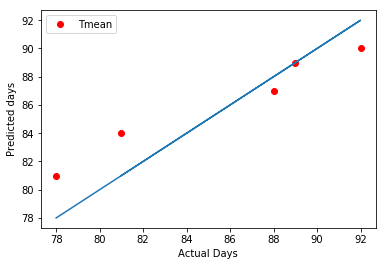

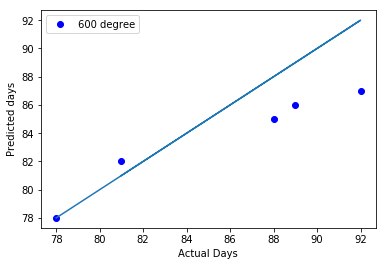

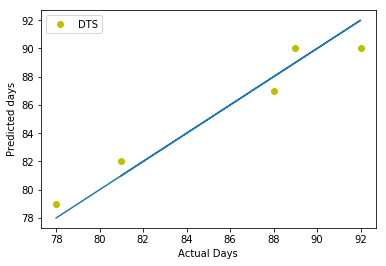

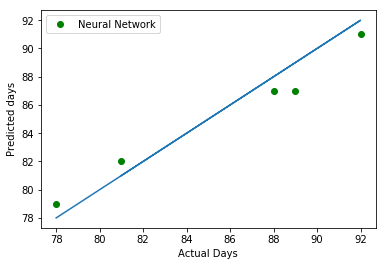

In [114]:
x=actualDays

plt.plot(x,predicted_Tmean,'ro',label="Tmean")
plt.plot(x,actualDays)
plt.xlabel("Actual Days")
plt.ylabel("Predicted days")
plt.legend()
plt.show()
plt.plot(x,predicted_600,'bo',label="600 degree")
plt.plot(x,actualDays)
plt.xlabel("Actual Days")
plt.ylabel("Predicted days")
plt.legend()
plt.show()
plt.plot(x,predicted_DTS,'yo',label="DTS")
plt.plot(x,actualDays)
plt.xlabel("Actual Days")
plt.ylabel("Predicted days")
plt.legend()
plt.show()
plt.plot(x,predicted_NN,'go',label="Neural Network")
plt.plot(x,actualDays)
plt.xlabel("Actual Days")
plt.ylabel("Predicted days")
plt.legend()
plt.show()



THE ACCURACIES OF THE DTS METHOD GIVES THE BEST RESULT SO FAR. THE 600 DEGREE METHOD IS TOO VAGUE AND IT WOULD BE BEST TO AVOID THIS METHOD. BUT IN THE CONTRARY, THE METHOD USING TMEAN GIVES LOWER ACCURACY THAN DTS METHOD BUT IT IS QUICKER TO DEAL WITH AND HENCE CAN BE USED FOR A VAGUE PREDICTION. BUT SINCE THE CHERRY BLOSSOM BLOOMING DEALS WITH A REACTION DEPENDENT ON TEMPERATURE, THERE ISN’T A LINEAR RELATIONSHIP BETWEEN BLOOM DATE AND TEMPERATURE AND HENCE DTS METHOD GIVES A BETTER RESULT THAN TMEAN OR 600 DEGREE RULE. THE NEURAL NETWORK DESIGNED IN THIS QUESTION WORKS IN A MANNER SIMILAR TO DTS METHOD AND WILL BE A BETTER OPTION SINCE IT PREVENTS THE USE OF HARD CODED PROGRAM AS DONE FOR DTS METHOD.

***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

THE MOST IMPORTANT FACTOR THAT AFFECTS THE BLOOM DATE OF THE CHERRY BLOSSOM TREES IS THE GEOGRAPHICAL LOCATION. IT IS ALREADY OBSERVED THAT IN MAJOR CITIES, TOKYO, KYOTO AND OSAKA, THE CHERRY BLOSSOM OCCURS IN EARLY APRIL. THIS PLAYED A VITAL ROLE IN FEATURE PREPROCESSING. THIS LED TO THE CONCLUSION THAT THE FIRST THREE MONTHS OF THE YEARS PLAYS A MAJOR ROLE IN CHERRY BLOSSOM BLOOM DATE AND THE REST OF THE DATA CAN BE DISCARDED FOR TRAINING THE NEURAL NETWORK

ANOTHER IMPORTANT FACTOR IS THE WEATHER WHICH VARIES FROM YEAR TO YEAR. NORMALLY, MILDER CLIMATE ENHANCES THE BLOOMING OF THE CHERRY BLOSSOM. ALSO, IT IS SEEN THAT CHERRY BLOSSOM BLOOMS ONLY DURING SPRING WHICH IS SANDWICHED BETWEEN WINTER AND SUMMER. THIS SHOWS THAT CHERRY BLOSSOM IS EXTREMELY SENSITIVE TO TEMPERATURE. IF THE WEATHER DURING THE MONTHS OR WEEKS IS MILD, THE CHERRY BLOSSOM BLOOMS EARLIER. IF THE WEATHER IS COLDER, THE BLOSSOM OPENS LATER.

THIS LED TO ANOTHER IMPORTANT FACT THAT THE BLOOM DATE IS MAINLY DEPENDENT ON THE TEMPERATURE OF THE WEATHER. SO FEATURES SUCH AS HUMIDITY AND PRESSURE HARDLY PLAY ANY ROLE IN THE BLOOMING PROCESS. HENCE, THESE FEATURES WERE DROPPED IN THE NEURAL NETWORK. 

IN SOME RESEARCHES, IT IS SEEN THAT HUMIDITY AND PRECIPITATION SUCH AS RAIN,  PLAYS AN IMPORTANT ROLE IN THE FALLING OF THE SAKURA PETALS THAN THE BLOOMING.

THE EFFECTS ARE SHOWN BELOW:
(NB: THE MISSING DATA OF YEAR 2017 CAUSES A SIGNIFICANT DROP IN THE GRAPHS, IT IS TO BE IGNORED FOR ANY DEDUCTION)


1.Processing the data for trend detection:

Mean of the entire data of the respective years are taken and then scaled for a better understanding

In [115]:
bloomDays=[(bloomModifiedDate[i]-dt.date(bloomModifiedDate[i].year,1,1)).days for i in range(len(bloomModifiedDate))]
x=years
data=sakuraFeatures.groupby([sakuraFeatures["year"]]).mean()
data=data.drop(["day","month"],axis=1)
data["bloom day"]=bloomDays
data["Dj"]=DJ
scaler=preprocessing.StandardScaler()
scaler.fit(data)
dataT=pd.DataFrame(scaler.transform(data),columns=data.columns.values)

2.Observing trend between Dj and BDj:

THE DIFFERENCE BETWEEN THESE TWO PLOTS SHOWS THE NUMBER OF DAYS SAKURA BLOSSOM TAKES TO BLOOM AFTER ITS HIBERNATION PHASE ENDS.

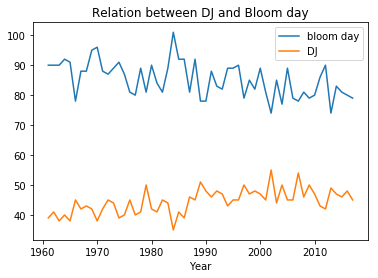

In [116]:
plt.plot(x,bloomDays,label="bloom day")
plt.plot(x,DJ,label="DJ")
plt.xlabel("Year")
plt.title("Relation between DJ and Bloom day")
plt.legend()
plt.show()

3.Observing the effect of temperature on bloom date:

IN THE PLOT BELOW, IT IS OBSERVED THAT THE TREND OF AVERAGE TEMPERATURE, MINIMUM TEMPARTURE AND MAX TEMPERATURE CHANGES AT ALMOST THE SAME MANNER. IF SEEN CLOSELY,AN INVERSE RELATION IS NOTICED WITH BOTH DJ AND BLOOM DATE, FOR EXAMPLE, A HIGHER TEMPERATURE LEADS TO AN EARLIER BLOOM DATE AND DJ WHICH IN THIS CASE IS DENOTED BY LESSER DAYS FROM 1ST JANUARY OF THE RESPECTIVE YEAR.

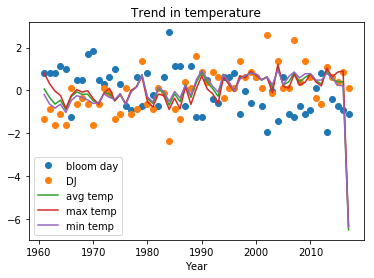

In [117]:
plt.plot(x,dataT["bloom day"],'o',label="bloom day")
plt.plot(x,dataT["Dj"],'o',label="DJ")
plt.plot(x,dataT["avg temp"],label="avg temp")
plt.plot(x,dataT["max temp"], label="max temp")
plt.plot(x,dataT["min temp"], label="min temp")
plt.xlabel("Year")
plt.title("Trend in temperature")
plt.legend()
plt.show()

4.Observing the effect of humidity on bloom date:

IN THE PLOT BELOW,JUST LIKE IN PREVIOUS FEATURE (temperature), BOTH AVERAGE AND MINIMUM HUMIDITY HAVE SIMILAR TREND. BUT A SPECIFIC TREND IN CORRESPONDNCE WITH BLOOMDATE AND DJ CAN'T BE FIGURED OUT. IN SOME POINTS, IT IS SEEN THAT HIGHER HUMIDITY QUICKENS THE BLOOMING BUT IT IS ALSO SEEN TO DELAY THE BLOOMING AS WELL. THIS LED TO THE DECISION OF DROPPING THE FEATURE FOR TRAINING THE NEURAL NETWORK.

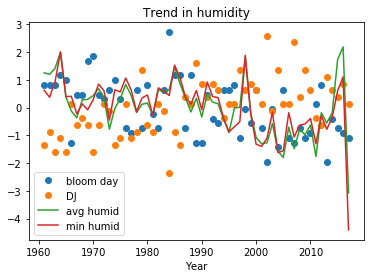

In [118]:
plt.plot(x,dataT["bloom day"],'o',label="bloom day")
plt.plot(x,dataT["Dj"],'o',label="DJ")
plt.plot(x,dataT["avg humid"],label="avg humid")
plt.plot(x,dataT["min humid"], label="min humid")
plt.xlabel("Year")
plt.title("Trend in humidity")
plt.legend()
plt.show()

5.Observing the effect of precipitation on bloom date:

IN THE PLOT BELOW,JUST LIKE IN PREVIOUS FEATURES (temperature and humidity), TOTAL, MIN10 AND HR1 HUMIDITY HAVE SIMILAR TREND. BUT A SPECIFIC TREND IN CORRESPONDNCE TO BLOOM DATE AND DJ CAN'T BE FIGURED OUT. THIS LED TO THE DECISION OF DROPPING THE FEATURE FOR TRAINING THE NEURAL NETWORK.

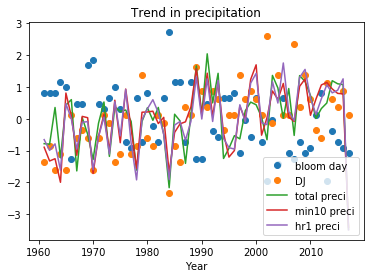

In [119]:
plt.plot(x,dataT["bloom day"],'o',label="bloom day")
plt.plot(x,dataT["Dj"],'o',label="DJ")
plt.plot(x,dataT["total preci"],label="total preci")
plt.plot(x,dataT["min10 preci"], label="min10 preci")
plt.plot(x,dataT["hr1 preci"], label="hr1 preci")
plt.xlabel("Year")
plt.title("Trend in precipitation")
plt.legend()
plt.show()

6.Observing the effect of pressure on bloom date:

IN THE PLOT BELOW,JUST LIKE IN PREVIOUS FEATURES (temperature, precipitation and humidity), SEA AND LOCAL PRESSURE HAVE SIMILAR TREND. BUT A SPECIFIC TREND IN CORRESPONDNCE TO BLOOM DATE AND DJ CAN'T BE FIGURED OUT. THIS LED TO THE DECISION OF DROPPING THE FEATURE FOR TRAINING THE NEURAL NETWORK.

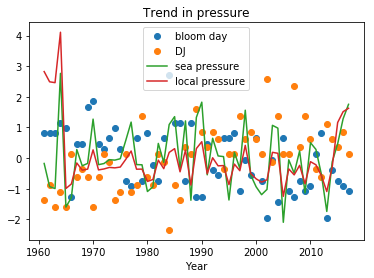

In [120]:
plt.plot(x,dataT["bloom day"],'o',label="bloom day")
plt.plot(x,dataT["Dj"],'o',label="DJ")
plt.plot(x,dataT["sea pressure"], label="sea pressure")
plt.plot(x,dataT["local pressure"], label="local pressure")
plt.xlabel("Year")
plt.title("Trend in pressure")
plt.legend()
plt.show()

7.Observing the effect of sun hour on bloom date:

IN THE PLOT BELOW, A SPECIFIC TREND IN CORRESPONDNCE TO BLOOM DATE AND DJ CAN'T BE FIGURED OUT. THIS LED TO THE DECISION OF DROPPING THE FEATURE FOR TRAINING THE NEURAL NETWORK.

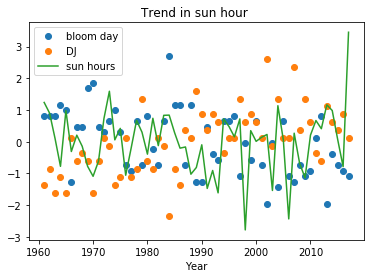

In [121]:
plt.plot(x,dataT["bloom day"],'o',label="bloom day")
plt.plot(x,dataT["Dj"],'o',label="DJ")
plt.plot(x,dataT["sun hours"], label="sun hours")
plt.xlabel("Year")
plt.title("Trend in sun hour ")
plt.legend()
plt.show()